**Курсовая работа**  
**Савин Александр Андреевич М80-407Б-19**  

**GPU Kernel Performance Dataset**

Используемый датасет: https://www.kaggle.com/datasets/rupals/gpu-runtime?datasetId=534866&sortBy=voteCount  
Задача: *Регрессия*

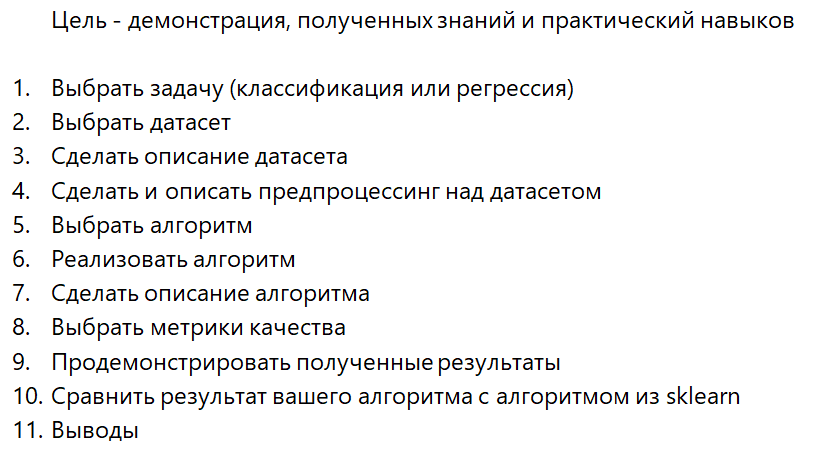

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import math

import seaborn as sns 
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

import io

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving sgemm_product.csv to sgemm_product (2).csv


In [4]:
df = pd.read_csv(io.StringIO(uploaded['sgemm_product.csv'].decode('utf-8')))
print('Df Shape : ',df.shape)

Df Shape :  (241600, 18)


**Описание параметров датасета с сайта**  
Independent variables:  
1-2. MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)  
3 KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)  
4-5. MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)  
6-7. MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)  
8 KWI: kernel loop unrolling factor: {2, 8} (integer)  
9-10. VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)  
11-12. STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)  
13-14. SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)  

Первые строчки датасета

In [5]:
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


Объединим параметры Run1,Run2,Run3,Run4 в одну переменную Runtime, используя среднее

In [6]:
df['Runtime']=df[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Runtime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625


Уберем ненужные поля Run1,Run2,Run3,Run4 и выведем информацию

In [7]:
df1=df.drop(columns =['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MWG      241600 non-null  int64  
 1   NWG      241600 non-null  int64  
 2   KWG      241600 non-null  int64  
 3   MDIMC    241600 non-null  int64  
 4   NDIMC    241600 non-null  int64  
 5   MDIMA    241600 non-null  int64  
 6   NDIMB    241600 non-null  int64  
 7   KWI      241600 non-null  int64  
 8   VWM      241600 non-null  int64  
 9   VWN      241600 non-null  int64  
 10  STRM     241600 non-null  int64  
 11  STRN     241600 non-null  int64  
 12  SA       241600 non-null  int64  
 13  SB       241600 non-null  int64  
 14  Runtime  241600 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB


Посмотрим распределение значений независимых параметров 

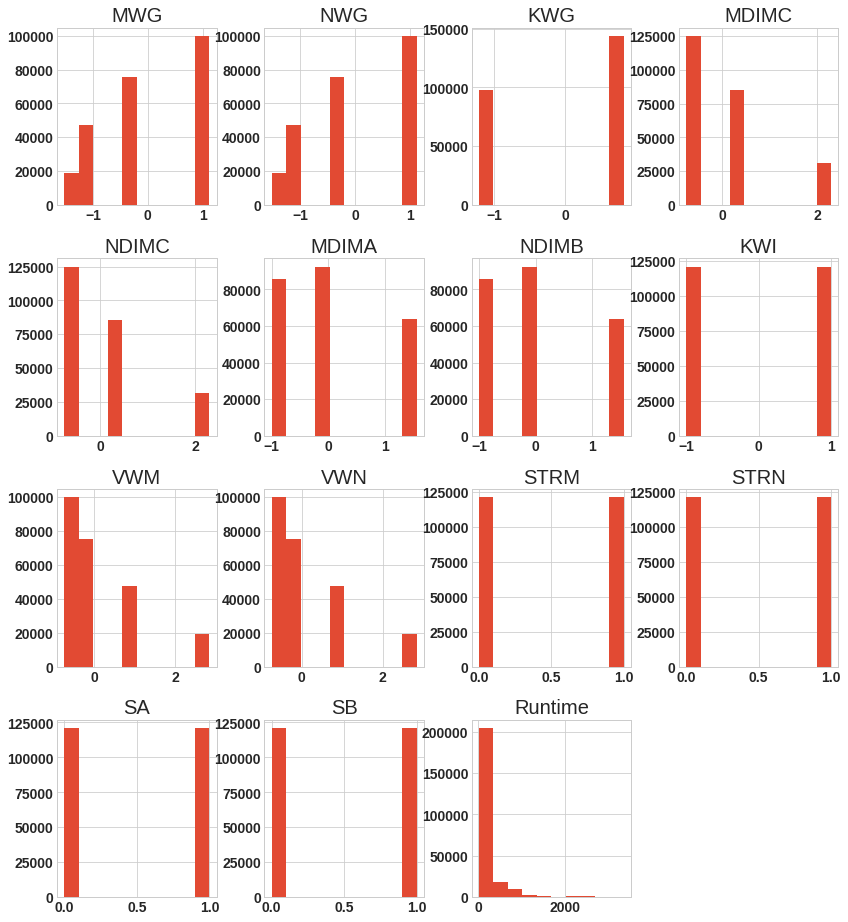

In [8]:
for index in range(10):
   df1.iloc[:,index] = (df1.iloc[:,index]-df1.iloc[:,index].mean()) / df1.iloc[:,index].std();
df1.hist(figsize= (14,16));

**Препроцессинг**

Проверим нулевые поля

In [9]:
df1.isnull().sum()

MWG        0
NWG        0
KWG        0
MDIMC      0
NDIMC      0
MDIMA      0
NDIMB      0
KWI        0
VWM        0
VWN        0
STRM       0
STRN       0
SA         0
SB         0
Runtime    0
dtype: int64

Корректируем данные Runtime за счет удаления выбросов, которые значительно отличаются от других значений.

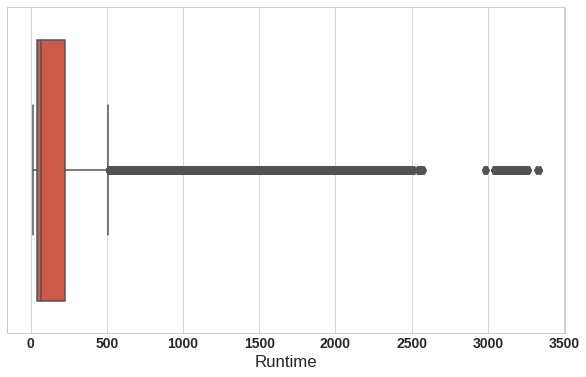

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(df1['Runtime']);

Здесь видно, что между 2500 и 3000 находится существенный разрыв, который может повлияеть на обучение, поэтому уберем данные правой части и начала левой, потом посмотрим на данные еще раз.

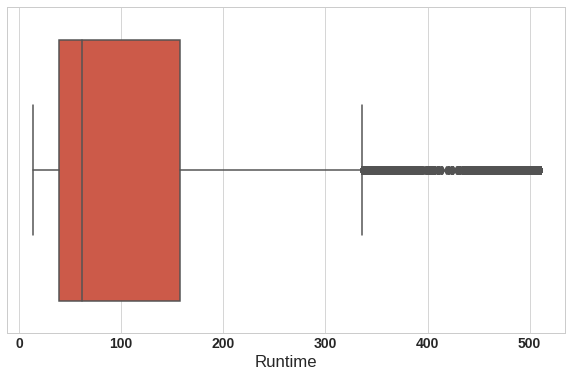

In [11]:
Q1=df1['Runtime'].quantile(0.25)
Q2=df1['Runtime'].quantile(0.75)
IQR = Q2 - Q1
LL=Q1-1.5*IQR
UL=Q2+1.5*IQR
df2 = df1[(df1.Runtime>LL) & (df1.Runtime<UL)]
plt.figure(figsize=(10,6))
sns.boxplot(df2['Runtime']);

Построим зависимости Runtime (у отредактированного датасета) от независимых параметров на примере MWG

Text(26.369999999999997, 0.5, 'Runtime')

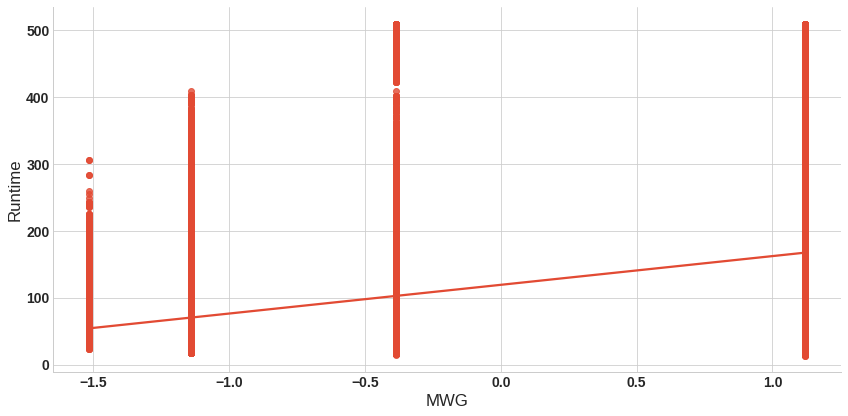

In [12]:
sns.lmplot(x='MWG',y='Runtime',data=df2,aspect=2,height=6)
plt.xlabel('MWG')
plt.ylabel('Runtime')

Теперь посмотрим на график значений Runtime в целом

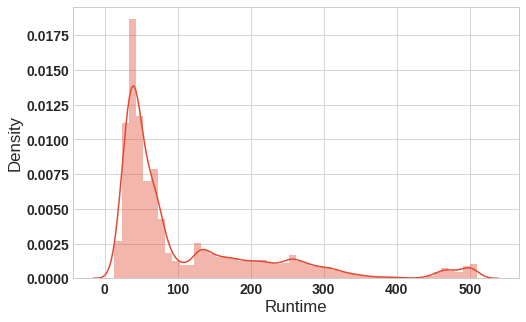

In [13]:
sns.distplot(df2['Runtime'])

Рассмотрим зависимости параметров друг от друга

Text(0.5, 1.0, 'Variable Correlation')

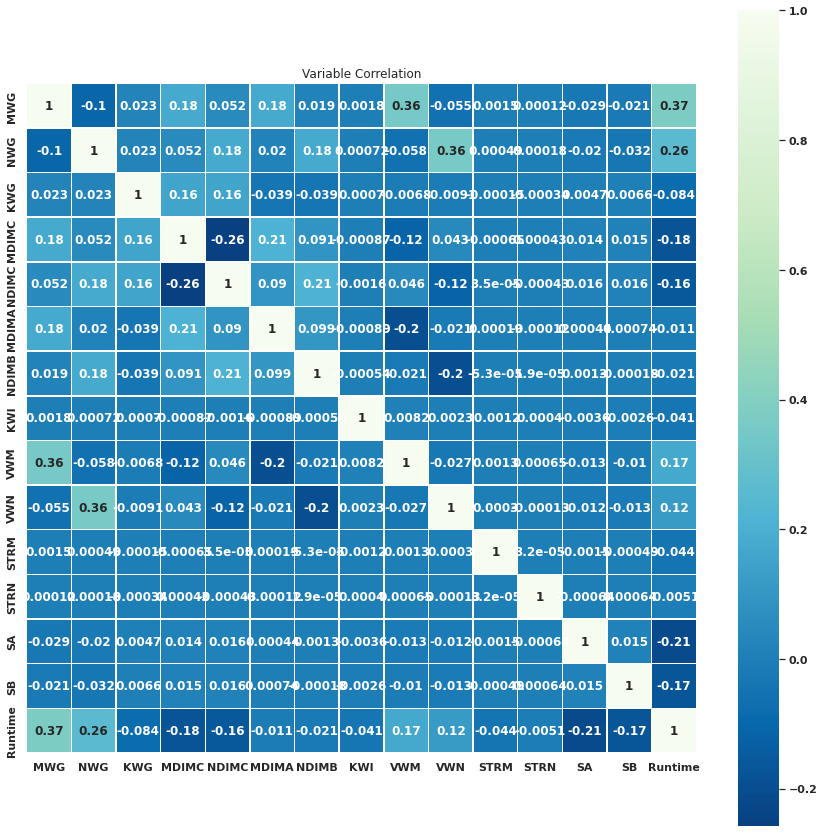

In [14]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(df2.corr(),cmap='GnBu_r',annot=True, square = True ,linewidths=.5);
plt.title('Variable Correlation')

**Обучение**  
**Выбранный алгоритм : Случайный лес**

**Описание алгоритма**  


Алгоритм основан на алгоритме деревьев решений. Сами по себе деревья решений не являются точными, но, когда их много, можно улучшить результат.    
DecisionTreeRegressor работает за счет построения дерева, где каждая ветка соответствует определенному значению параметров.  
Изначально для случайного леса создается некоторое количество случайно сгененерированных деревьев решений.  
Описание параметров:  
*n_estimators* - количество деревьев решений  
*max_depth* - максимальная глубина каждого дерева  
*max_features* - максимальное число признаков, учитывающийся при разделении  


На картинке изоброжен пример построения дерева решений:  
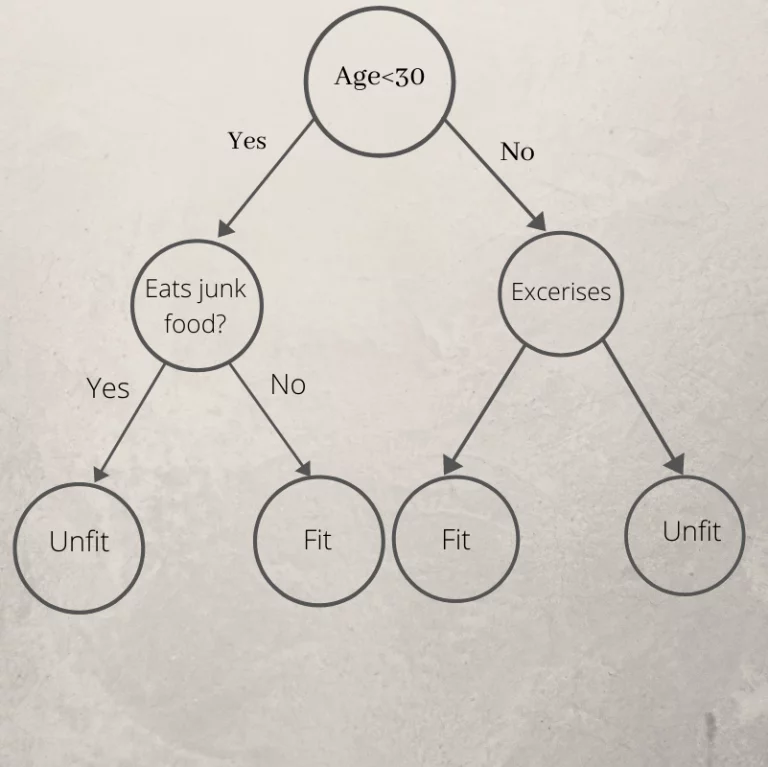

Алгоритм Случайный Лес можно представить в виде следующей структуры:  
- Каждое дерево решений создается из различных наборов рядов, на каждом узле дерева выбирается параметр для разделения.  
- Каждое дерево решений делает собственное предсказание  
- Усредняем значение предсказаний и получаем конечный результат 

Класс на основе DecisionTreeRegressor из Sklearn

In [15]:
import copy
from sklearn.tree import DecisionTreeRegressor
class MyRandomForestRegressor:
    def __init__(self, n_estimators, max_depth=None, min_samples_split=20, max_features=0.5, min_impurity_decrease=0):
        self.n_estimators = n_estimators
        self.base_estimator = DecisionTreeRegressor(max_depth=max_depth, 
                                                    min_samples_split=min_samples_split, max_features=max_features, 
                                                    min_impurity_decrease=min_impurity_decrease)
        self.estimators = None
        
    def fit(self, X, y):
        self.estimators = []
        for estimator_i in range(self.n_estimators):
            idx = np.random.randint(low=0, high=len(X), size=len(X))
            X_bs = X[idx, :]
            y_bs = y[idx]
            new_estimator = copy.copy(self.base_estimator)
            new_estimator.fit(X_bs, y_bs)
            self.estimators.append(new_estimator)
    
    def predict(self, X):
        predictions = np.stack([estimator.predict(X) for estimator in self.estimators], axis=1) 
        return predictions.mean(axis=1)

Делим таблицу на тестовые и тренировочные данные

In [16]:
features = df2.loc[:, df2.columns!="Runtime"].to_numpy()
labels = df2.loc[:, "Runtime"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

Выбранные метрики: Root Mean Squared Error, R-squared Error  
Выполняем проверки для тестовых и тренировачных данных

Запускаем реализацию случайного леса с использованием DecisionTreeRegressor из sklearn

In [17]:
regressor = MyRandomForestRegressor(100)
regressor.fit(X_train, y_train)

In [18]:
predictions_train = regressor.predict(X_train)
rmse_train = np.sqrt(np.square(y_train - predictions_train)).mean()
r2_train = 1 - np.square(y_train - predictions_train).sum()/np.square(y_train - y_train.mean()).sum()

print(f"Root mean squared error = {rmse_train}\nR-squared = {r2_train}")

Root mean squared error = 3.8022656596878286
R-squared = 0.9963381586498241


In [19]:
predictions = regressor.predict(X_test)
rmse = np.sqrt(np.square(y_test - predictions)).mean()
r2 = 1 - np.square(y_test - predictions).sum()/np.square(y_test - y_test.mean()).sum()

print(f"Root mean squared error = {rmse}\nR-squared = {r2}")

Root mean squared error = 4.432280915354341
R-squared = 0.9948957228702826


---

Реализация RandomForestRegressor из Sklearn

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
skregressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
skregressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Смотрим на результаты

In [21]:
y_pred_train = skregressor.predict(X_train) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('R-squared:', metrics.r2_score(y_train, y_pred_train))

Root Mean Squared Error: 1.158096803311592
R-squared: 0.9998969533218676


In [22]:
y_pred_test = skregressor.predict(X_test) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('R-squared:', metrics.r2_score(y_test, y_pred_test))

Root Mean Squared Error: 2.991280165280606
R-squared: 0.9993019157010732


По значению R-squared ошибки результаты практически идентичны (с точностью до 0.01).  
По значению Root Mean Squared Error RandomForestRegressor из Sklearn превосходит мою реализацию.

---

Рассмотрим полную реализацию дерева решения, которая будет работать вместо альтернативы из Sklearn

In [23]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        self.value = value

class MyDecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["var_red"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_var_red = -float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [24]:
import copy
from sklearn.tree import DecisionTreeRegressor
class MyRandomForestRegressor2:
    def __init__(self, n_estimators, max_depth=None, min_samples_split=20, max_features=0.5, min_impurity_decrease=0):
        self.n_estimators = n_estimators
        self.base_estimator = MyDecisionTreeRegressor(min_samples_split=20, max_depth=3)
        self.estimators = None
        
    def fit(self, X, y):
        self.estimators = []
        for estimator_i in range(self.n_estimators):
            idx = np.random.randint(low=0, high=len(X), size=len(X))
            X_bs = X[idx, :]
            y_bs = y[idx]
            new_estimator = copy.copy(self.base_estimator)
            new_estimator.fit(X_bs, y_bs)
            self.estimators.append(new_estimator)
    
    def predict(self, X):
        predictions = np.stack([estimator.predict(X) for estimator in self.estimators], axis=1) 
        return predictions.mean(axis=1)

Сделаем отдельное разбиение на тестовые и тренировочные данные для новой реализации.

In [25]:
X = df2.iloc[:, :-1].values
Y = df2.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=.2)

Обучим сеть на 20 внутренних деревьях

In [34]:
import math
myregressor2 = MyRandomForestRegressor2(20)
myregressor2.fit(X_train1, Y_train1)

In [35]:
predictions_test1 = regressor.predict(X_test1)

In [36]:
import math
avg = 0
for i in range(len(X_test1)):
  avg += math.sqrt(abs(Y_train1[i] - predictions_test1[i]))
avg = avg / len(X_train1)
avg = math.sqrt(avg)
print(f"Root mean squared error = {avg}")

Root mean squared error = 1.4916188462345852


К сожалению, результат вышел хуже чем в обеих предыдущих реализациях. Одна из причин - длительное время работы и недостаточность некоторых параметров в моей реализации Дерева Решений. 

**Вывод**  
Выполняя курсовой проект, я расширил свои знания о препроцессинге и общей подготовке данных для обучения. Лучше разобрался с алгоритмоми для решения задач регрессии "Случайным Лес" и "Дерево Решений".  
Препроцессинг сыграл важную роль в подготовке данных для обучения, так как некоторые эксземпляры были убраны ради более правильного обучения. Нулевых элементов в датасете не было.  
По итогу, лучше всего справился полный алгоритм из Sklearn, чуть хуже, но все равно достаточно хорошо справился написанный мною алгоритм случайного леса, работающий на базе алгоритма дерева решений из пакета Sklearn. Хуже всего справилась моя полная реализация.